In [23]:
import praw
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from pprint import pprint

In [4]:
#Loading the data that was generated in the previous notebook
df = pd.read_csv('final_data2.csv')
df_original_copy = df

In [5]:
df.head()

,flair,title,url,text,score,num_comments,original,comments,polarity
0,0,Ethereum Fees Now at July 2021 Lows of $2.54 -...,https://cryptonewsland.com/ethereum-fees-now-a...,NaN,21,14,False,Ethereum [pros](/r/CryptoMarkets/comments/ux7...,0.9497
1,0,Coinbase CEO’s Response to Employee Rant Backf...,https://cryptonewsland.com/coinbase-ceos-respo...,NaN,4,7,False,USDC [pros](/r/CryptoMarkets/comments/v9izys/...,-0.4404
2,0,Mars4 Metaverse is Selling Fast in Japan – Spo...,https://news.bitcoin.com/mars4-metaverse-is-se...,NaN,2,9,False,Bitcoin [pros](/r/CryptoMarkets/comments/v9vc...,-0.2732
3,0,Terra Crisis: G-7 Nations Call for Urgent Cryp...,https://crypto.news/terra-g-7-nations-urgent-c...,NaN,14,13,False,Do Kwan screwed us. They were just looking fo...,0.6705
4,0,White House says the Administration is Closely...,https://www.youtube.com/watch?v=4oSL1gCHFdQ,NaN,0,4,False,Inflation [pros](/r/CryptoMarkets/comments/vd...,0.8979


In [6]:
df.describe()

,flair,score,num_comments,polarity
count,1120.000000,1120.000000,1120.000000,1120.000000
mean,6.080357,30.849107,30.390179,0.317910
std,4.022142,91.558395,75.575886,0.529006
min,0.000000,0.000000,0.000000,-0.997500
25%,2.000000,1.000000,2.000000,0.000000
50%,7.000000,4.000000,9.000000,0.000000
75%,10.000000,19.000000,23.000000,0.897900
max,12.000000,1242.000000,1139.000000,1.000000


In [7]:
df.isnull().sum()

flair             0
title             0
url               0
text            703
score             0
num_comments      0
original          0
comments        339
polarity          0
dtype: int64

In [8]:
df.flair.value_counts()

0     100
1     100
2     100
3     100
4     100
7     100
8     100
9     100
10    100
11    100
12    100
5      10
6      10
Name: flair, dtype: int64

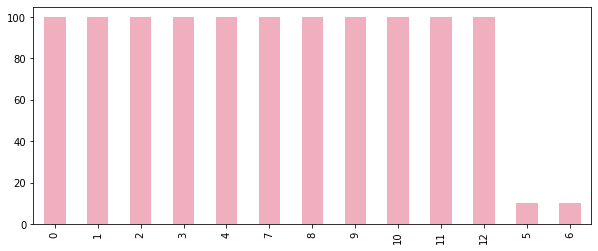

In [9]:
plt.figure(figsize=(10,4))
df.flair.value_counts().plot(kind='bar', color='#f0afbf');

In [10]:
df.drop(df[df['flair'] == 5].index, inplace = True) 
df.drop(df[df['flair'] == 6].index, inplace = True) 

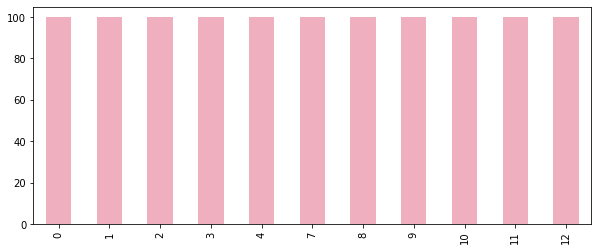

In [11]:
plt.figure(figsize=(10,4))
df.flair.value_counts().plot(kind='bar', color='#f0afbf');

# Selecting and Training a Model

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [13]:
X = df.title.values.astype('U')
y = df.flair
encoder = LabelEncoder()
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 11)


In [14]:
print("Number of samples in  X_train: ", X_train.shape) 
print("Number of samples in y_train: ", y_train.shape) 
print("Number of samples in X_test: ", X_test.shape) 
print("Number of samples in y_test: ", y_test.shape) 

Number of samples in  X_train:  (770,)
Number of samples in y_train:  (770,)
Number of samples in X_test:  (330,)
Number of samples in y_test:  (330,)


In [15]:
from xgboost import XGBClassifier

In [16]:
def logistic_reg(X_train, y_train):
    logreg = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf', LogisticRegression(n_jobs=1, C=1e5, max_iter=5000)),
                   ])
    lr = logreg.fit(X_train, y_train)
    
    return lr


def linear_svm(X_train, y_train):
    sgd = Pipeline([('tfidf', TfidfVectorizer()),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=1000, tol=None)),
                   ])
    
    svm = sgd.fit(X_train, y_train)
  
    return svm


def naive_bayes(X_train, y_train):
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.pipeline import Pipeline
    from sklearn.feature_extraction.text import TfidfTransformer

    nb = Pipeline([('tfidf', TfidfVectorizer()),
                   ('clf', MultinomialNB()),
                  ])
    
    n = nb.fit(X_train, y_train)

    return n


def decision_trees(X_train, y_train):
    dt = Pipeline([('tfidf', TfidfVectorizer()),
                   ('clf', DecisionTreeClassifier()),
                  ])
    
    d = dt.fit(X_train,y_train)
    
    return d


def random_forest(X_train, y_train):
    ranfor = Pipeline([('tfidf', TfidfVectorizer()),
                  ('clf', RandomForestClassifier(n_estimators = 1000, random_state = 42)),
                 ])
    
    rf = ranfor.fit(X_train, y_train)

    return rf


# Comparing different models

In [17]:
data_lr = []
data_svm = []
data_nb = []
data_dt = []
data_rf = []

for i in range(1,8):
    xtr = X_train[0:i*100]
    ytr = y_train[0:i*100]
    clflr = logistic_reg(xtr, ytr)
    clfsvm = linear_svm(xtr, ytr)
    clfnb = naive_bayes(xtr, ytr)
    clfdt = decision_trees(xtr, ytr)
    clfrf = random_forest(xtr, ytr)
    
    data_lr.append(clflr.score(X_test,y_test))
    data_svm.append(clfsvm.score(X_test,y_test))
    data_nb.append(clfnb.score(X_test,y_test))
    data_dt.append(clfdt.score(X_test, y_test))
    data_rf.append(clfrf.score(X_test, y_test))


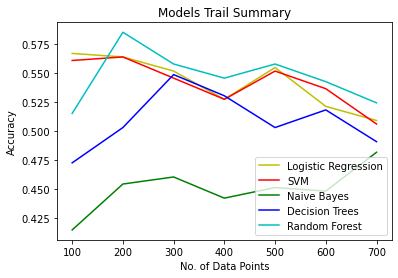

In [18]:
plt.plot([100,200,300,400,500,600,700],data_lr,color='y')
plt.plot([100,200,300,400,500,600,700],data_svm,color='r')
plt.plot([100,200,300,400,500,600,700],data_nb,color='g')
plt.plot([100,200,300,400,500,600,700],data_dt,color='b')
plt.plot([100,200,300,400,500,600,700],data_rf,color='c')
plt.gca().legend(('Logistic Regression', 'SVM','Naive Bayes','Decision Trees','Random Forest'))
plt.xlabel('No. of Data Points')
plt.ylabel('Accuracy')
plt.title('Models Trail Summary')
plt.show()

In [19]:
print("Final Accuracies with 800 data points:")
print("Logistic Regression: {} ".format(data_lr[-1]))
print("Support Vector Machine: {}".format(data_svm[-1]))
print("Naive Bayes: {}".format(data_nb[-1]))
print("Decision Trees: {}".format(data_dt[-1]))
print("Random Forest: {}".format(data_rf[-1]))

Final Accuracies with 800 data points:
Logistic Regression: 0.509090909090909 
Support Vector Machine: 0.5060606060606061
Naive Bayes: 0.4818181818181818
Decision Trees: 0.4909090909090909
Random Forest: 0.5242424242424243


# Training on the whole dataset
**Random forests** seem to perform better compared to other models. The *low accuracy* is result of considering a small subset of the dataset. A better accuracy should be obtained after using the whole dataset.


In [25]:
df.head(1)

,flair,title,url,text,score,num_comments,original,comments,polarity
0,0,Ethereum Fees Now at July 2021 Lows of $2.54 -...,https://cryptonewsland.com/ethereum-fees-now-a...,NaN,21,14,False,Ethereum [pros](/r/CryptoMarkets/comments/ux7...,0.9497


In [26]:
random_forest_pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                  ('clf', RandomForestClassifier(n_estimators = 1000, random_state = 42)),
                 ])

In [36]:
# Using X_train which only contains title
rf_clf = random_forest_pipeline.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print('Accuracy: %s' % accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5151515151515151
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.71      0.65      0.68        23
           2       0.18      0.23      0.21        30
           3       0.77      0.75      0.76        32
           4       0.48      0.44      0.46        27
           5       0.93      1.00      0.96        27
           6       0.91      0.81      0.85        36
           7       0.14      0.21      0.16        24
           8       0.05      0.03      0.04        31
           9       0.72      0.72      0.72        36
          10       0.63      0.73      0.68        33

    accuracy                           0.52       330
   macro avg       0.50      0.51      0.50       330
weighted avg       0.51      0.52      0.51       330



In [29]:
X2 = df.title + df.url
X2 = X2.values.astype('U')
y2 = df.flair
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state = 27)

rf_clf2 = random_forest_pipeline.fit(X2_train, y2_train)
y2_pred = rf_clf2.predict(X2_test)
print('Accuracy: %s' % accuracy_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

Accuracy: 0.46060606060606063
              precision    recall  f1-score   support

           0       0.15      0.19      0.17        26
           1       0.79      0.59      0.68        39
           2       0.12      0.09      0.10        33
           3       0.60      0.68      0.63        37
           4       0.32      0.21      0.25        29
           7       0.87      0.96      0.91        27
           8       0.89      0.74      0.81        23
           9       0.23      0.29      0.25        28
          10       0.18      0.12      0.15        32
          11       0.62      0.68      0.65        31
          12       0.35      0.56      0.43        25

    accuracy                           0.46       330
   macro avg       0.46      0.46      0.46       330
weighted avg       0.47      0.46      0.46       330



In [38]:
X2 = df.title + df.text
X2 = X2.values.astype('U')
y2 = df.flair
y2 = LabelEncoder().fit_transform(y2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state = 27)

rf_clf2 = random_forest_pipeline.fit(X2_train, y2_train)
y2_pred = rf_clf2.predict(X2_test)
print('Accuracy: %s' % accuracy_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

Accuracy: 0.23333333333333334
              precision    recall  f1-score   support

           0       0.09      0.73      0.17        26
           1       0.68      0.33      0.45        39
           2       0.00      0.00      0.00        33
           3       0.86      0.51      0.64        37
           4       0.12      0.03      0.05        29
           5       0.31      0.19      0.23        27
           6       0.83      0.22      0.34        23
           7       0.14      0.07      0.10        28
           8       0.00      0.00      0.00        32
           9       0.67      0.06      0.12        31
          10       0.32      0.44      0.37        25

    accuracy                           0.23       330
   macro avg       0.37      0.24      0.23       330
weighted avg       0.38      0.23      0.23       330



In [39]:
X2 = df.title + df.comments
X2 = X2.values.astype('U')
y2 = df.flair
y2 = LabelEncoder().fit_transform(y2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state = 27)

rf_clf2 = random_forest_pipeline.fit(X2_train, y2_train)
y2_pred = rf_clf2.predict(X2_test)
print('Accuracy: %s' % accuracy_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

Accuracy: 0.37272727272727274
              precision    recall  f1-score   support

           0       0.14      0.19      0.16        26
           1       0.83      0.49      0.61        39
           2       0.00      0.00      0.00        33
           3       0.58      0.57      0.58        37
           4       0.20      0.07      0.10        29
           5       0.76      0.70      0.73        27
           6       0.86      0.52      0.65        23
           7       0.24      0.29      0.26        28
           8       0.00      0.00      0.00        32
           9       0.22      0.84      0.35        31
          10       0.52      0.44      0.48        25

    accuracy                           0.37       330
   macro avg       0.40      0.37      0.36       330
weighted avg       0.39      0.37      0.36       330



In [40]:
X2 = df.url
X2 = X2.values.astype('U')
y2 = df.flair
y2 = LabelEncoder().fit_transform(y2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state = 27)

rf_clf2 = random_forest_pipeline.fit(X2_train, y2_train)
y2_pred = rf_clf2.predict(X2_test)
print('Accuracy: %s' % accuracy_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

Accuracy: 0.23939393939393938
              precision    recall  f1-score   support

           0       0.05      0.08      0.06        26
           1       0.29      0.05      0.09        39
           2       0.10      0.12      0.11        33
           3       0.20      0.59      0.30        37
           4       0.21      0.21      0.21        29
           5       0.84      0.59      0.70        27
           6       0.67      0.26      0.38        23
           7       0.15      0.14      0.15        28
           8       0.06      0.03      0.04        32
           9       0.52      0.42      0.46        31
          10       0.33      0.12      0.18        25

    accuracy                           0.24       330
   macro avg       0.31      0.24      0.24       330
weighted avg       0.30      0.24      0.23       330



In [37]:
X2 = df.title + df.comments + df.url + df.text
X2 = X2.values.astype('U')
y2 = df.flair
y2 = LabelEncoder().fit_transform(y2)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state = 27)

rf_clf2 = random_forest_pipeline.fit(X2_train, y2_train)
y2_pred = rf_clf2.predict(X2_test)
print('Accuracy: %s' % accuracy_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

Accuracy: 0.21818181818181817
              precision    recall  f1-score   support

           0       0.10      0.81      0.17        26
           1       0.59      0.33      0.43        39
           2       0.00      0.00      0.00        33
           3       0.88      0.57      0.69        37
           4       0.00      0.00      0.00        29
           5       0.29      0.15      0.20        27
           6       1.00      0.22      0.36        23
           7       0.20      0.11      0.14        28
           8       0.00      0.00      0.00        32
           9       0.00      0.00      0.00        31
          10       0.28      0.20      0.23        25

    accuracy                           0.22       330
   macro avg       0.30      0.22      0.20       330
weighted avg       0.31      0.22      0.21       330



# Conclusion
The best accuray is obtained by using **Title** as a predictor of flair compared to other combination of features such as **Title + Text + Comments + Url**, **Title + Url**, etc.

# Saving the model

In [41]:
import joblib

joblib.dump(rf_clf, 'trained_rfmodel.pkl')

['trained_rfmodel.pkl']